In [1]:
import matplotlib.pyplot as plt
import norse.torch as snn
import torch

In [2]:
from ipywidgets import interact, IntSlider, FloatSlider
from functools import partial

IntSlider = partial(IntSlider, continuous_update=False)
FloatSlider = partial(FloatSlider, continuous_update=False)

In [3]:
def integrate_and_record_voltages(cell):
    def integrate(input_currents):
        T = input_currents.shape[0]
        s = None
        spikes = []
        voltage_trace = []
        for ts in range(T):
            z, s = cell(input_currents[ts], s)
            spikes.append(z)
            voltage_trace.append(s.v)
        return torch.stack(spikes), torch.stack(voltage_trace)

    return integrate

interactive(children=(FloatSlider(value=40.0, continuous_update=False, description='tau_mem', max=200.0, min=1…

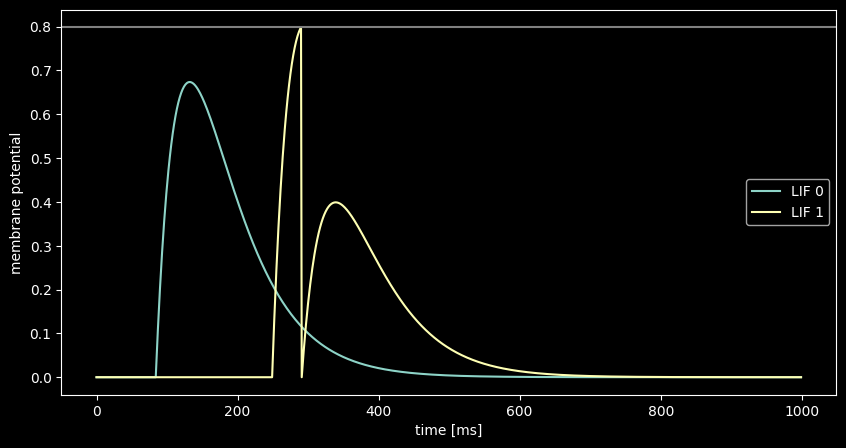

In [4]:
@interact(
    tau_mem=FloatSlider(min=10, max=200, step=1.0, value=40),
    tau_syn=FloatSlider(min=10, max=200, step=1.0, value=60),
    v_th=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.8),
    t1=IntSlider(min=0, max=1000, step=1, value=85),
    t2=IntSlider(min=0, max=1000, step=1, value=250),
)
def experiment(tau_mem, tau_syn, v_th, t1, t2):
    plt.figure(figsize=(10, 5))
    num_neurons = 2
    tau_syn_inv = torch.tensor([1 / (tau_syn * 0.001)])
    tau_mem_inv = torch.tensor([1 / (tau_mem * 0.001)])
    data = torch.zeros(1000, num_neurons)
    data[t1][0] = 1.5  # Neuron 1 current at time t1
    data[t2][1] = 1.8  # Neuron 2 current at time t2

    cell = snn.LIFCell(
        p=snn.LIFParameters(
            tau_mem_inv=tau_mem_inv,
            tau_syn_inv=tau_syn_inv,
            v_th=torch.as_tensor(v_th),
        )
    )

    lif_integrate = integrate_and_record_voltages(cell)
    zs, lif_voltage_trace = lif_integrate(data)
    plt.xlabel("time [ms]")
    plt.ylabel("membrane potential")
    plt.plot(lif_voltage_trace.detach(), label=[f"LIF {i}" for i in range(num_neurons)])
    plt.axhline(v_th, color="grey")
    plt.legend()